# Stablecoin Ratio Analysis

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests 
from datetime import datetime
import json
from web3 import Web3
from web3.middleware import (
    ExtraDataToPOAMiddleware,
    PythonicMiddleware,
)

# constants
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]
selected_coins = ['BTC', 'USDT', 'BUSD', 'TUSD', 'FDUSD']
selected_columns = ['coin', 'balance']

# Connect to BNB Chain (BSC) RPC
bsc_rpc = "https://bsc-dataseed.binance.org/"
web3 = Web3(Web3.HTTPProvider(bsc_rpc))

## 1. Monthly data from Binance

In [24]:

df = pd.DataFrame()
for month in months:
    pdf = pd.read_csv(f"bn_reserved/bn_{month}.csv")[selected_columns]
    pdf['month'] = month
    # Filter for BTC and stablecoins
    pdf = pdf[pdf['coin'].isin(selected_coins)]
    df = pd.concat([df, pdf])

# Reset the index to ensure it's unique across all months
df = df.reset_index(drop=True)

# Convert 'balance' to numeric, handling any non-numeric values
df['balance'] = pd.to_numeric(df['balance'], errors='coerce')

# Convert 'month' to datetime for easier sorting and plotting
df['month'] = pd.to_datetime('2024-' + df['month'])

df 

,coin,balance,month
0,BTC,3.704665e+02,2024-01-01
1,BTC,2.950640e+03,2024-01-01
2,BTC,5.274913e+03,2024-01-01
3,BTC,5.110073e+02,2024-01-01
4,BTC,0.000000e+00,2024-01-01
...,...,...,...
1589,USDT,4.681473e+07,2024-10-01
1590,USDT,5.500000e+08,2024-10-01
1591,USDT,1.437661e+07,2024-10-01
1592,USDT,1.100000e+09,2024-10-01


In [25]:
# Create a mapping dictionary for stablecoins
stablecoin_mapping = {
    'USDT': 'stablecoin',
    'BUSD': 'stablecoin',
    'TUSD': 'stablecoin',
    'FDUSD': 'stablecoin'
}

# Apply the mapping to convert stablecoins to 'SDUSD'
df['coin'] = df['coin'].replace(stablecoin_mapping)

# Group by 'coin' and 'month', then sum the 'balance'
df = df.groupby(['coin', 'month'])['balance'].sum().reset_index()

# Display the updated DataFrame
print(df)


          coin      month       balance
0          BTC 2024-01-01  5.976581e+05
1          BTC 2024-02-01  6.094771e+05
2          BTC 2024-03-01  5.804644e+05
3          BTC 2024-04-01  5.941360e+05
4          BTC 2024-05-01  6.175342e+05
5          BTC 2024-06-01  6.213290e+05
6          BTC 2024-07-01  6.453852e+05
7          BTC 2024-08-01  6.523706e+05
8          BTC 2024-09-01  6.471058e+05
9          BTC 2024-10-01  6.362280e+05
10  stablecoin 2024-01-01  2.505586e+10
11  stablecoin 2024-02-01  2.479526e+10
12  stablecoin 2024-03-01  2.476388e+10
13  stablecoin 2024-04-01  2.636588e+10
14  stablecoin 2024-05-01  3.034312e+10
15  stablecoin 2024-06-01  2.780397e+10
16  stablecoin 2024-07-01  2.660193e+10
17  stablecoin 2024-08-01  2.570806e+10
18  stablecoin 2024-09-01  2.741386e+10
19  stablecoin 2024-10-01  2.629115e+10


In [26]:
# Read the CSV file
binance_data = pd.read_csv("binance_btcusdt_data.csv")

# Convert the 'date' column to datetime
binance_data['timestamp'] = pd.to_datetime(binance_data['timestamp'])

# Set 'date' as the index
binance_data.set_index('timestamp', inplace=True)

# Filter for dates in 2024
binance_data_2024 = binance_data.loc['2024-01-01':'2024-10-31']

# Resample to get the first day of each month and select the 'close' price
monthly_prices = binance_data_2024.resample('MS')['close'].first()



In [27]:

# Create a DataFrame with BTC prices
btc_prices = pd.DataFrame({'coin': 'BTC', 'month': monthly_prices.index, 'price': monthly_prices.values})

# Create a DataFrame with SDUSD prices (always 1)
sdusd_prices = pd.DataFrame({'coin': 'stablecoin', 'month': monthly_prices.index, 'price': 1})

# Combine BTC and SDUSD price DataFrames
price_df = pd.concat([btc_prices, sdusd_prices])

# Merge the price data with the existing df
df = df.merge(price_df, on=['coin', 'month'], how='left')

# For coins other than BTC and SDUSD, set price to NaN
df.loc[~df['coin'].isin(['BTC', 'stablecoin']), 'price'] = np.nan

# Calculate the USD value of the balance
df['usd_value'] = df['balance'] * df['price']

# Display the updated DataFrame
print(df)

          coin      month       balance     price     usd_value
0          BTC 2024-01-01  5.976581e+05  42475.23  2.538566e+10
1          BTC 2024-02-01  6.094771e+05  42474.95  2.588751e+10
2          BTC 2024-03-01  5.804644e+05  61501.11  3.569921e+10
3          BTC 2024-04-01  5.941360e+05  71152.86  4.227448e+10
4          BTC 2024-05-01  6.175342e+05  60240.57  3.720061e+10
5          BTC 2024-06-01  6.213290e+05  67655.66  4.203642e+10
6          BTC 2024-07-01  6.453852e+05  62931.99  4.061538e+10
7          BTC 2024-08-01  6.523706e+05  64645.90  4.217308e+10
8          BTC 2024-09-01  6.471058e+05  58930.00  3.813394e+10
9          BTC 2024-10-01  6.362280e+05  63531.99  4.042083e+10
10  stablecoin 2024-01-01  2.505586e+10      1.00  2.505586e+10
11  stablecoin 2024-02-01  2.479526e+10      1.00  2.479526e+10
12  stablecoin 2024-03-01  2.476388e+10      1.00  2.476388e+10
13  stablecoin 2024-04-01  2.636588e+10      1.00  2.636588e+10
14  stablecoin 2024-05-01  3.034312e+10 

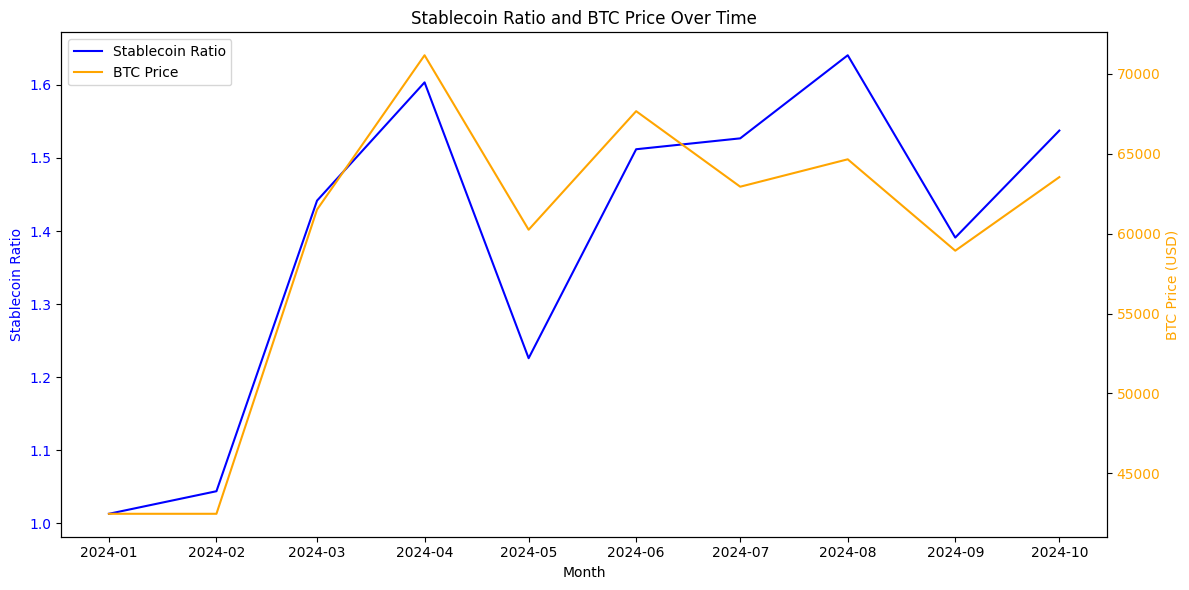

coin      month           BTC    stablecoin  stablecoin_ratio  btc_price
0    2024-01-01  2.538566e+10  2.505586e+10          1.013163   42475.23
1    2024-02-01  2.588751e+10  2.479526e+10          1.044051   42474.95
2    2024-03-01  3.569921e+10  2.476388e+10          1.441584   61501.11
3    2024-04-01  4.227448e+10  2.636588e+10          1.603378   71152.86
4    2024-05-01  3.720061e+10  3.034312e+10          1.225998   60240.57
5    2024-06-01  4.203642e+10  2.780397e+10          1.511886   67655.66
6    2024-07-01  4.061538e+10  2.660193e+10          1.526783   62931.99
7    2024-08-01  4.217308e+10  2.570806e+10          1.640462   64645.90
8    2024-09-01  3.813394e+10  2.741386e+10          1.391046   58930.00
9    2024-10-01  4.042083e+10  2.629115e+10          1.537431   63531.99


In [28]:
# Group by month and coin, summing the USD values
monthly_usd_values = df.groupby(['month', 'coin'])['usd_value'].sum().unstack()

# Calculate the stablecoin ratio (BTC USD value / SDUSD USD value)
monthly_usd_values['stablecoin_ratio'] = monthly_usd_values['BTC'] / monthly_usd_values['stablecoin']

# Reset the index to make 'month' a column again
monthly_usd_values.reset_index(inplace=True)

# Add BTC price to the monthly_usd_values DataFrame
monthly_usd_values['btc_price'] = monthly_prices.values

# Create a plot
plt.figure(figsize=(12, 6))

# Plot stablecoin ratio
ax1 = plt.gca()
ax1.plot(monthly_usd_values['month'], monthly_usd_values['stablecoin_ratio'], label='Stablecoin Ratio', color='blue')
ax1.set_xlabel('Month')
ax1.set_ylabel('Stablecoin Ratio', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for BTC price
ax2 = ax1.twinx()
ax2.plot(monthly_usd_values['month'], monthly_usd_values['btc_price'], label='BTC Price', color='orange')
ax2.set_ylabel('BTC Price (USD)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')


# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Stablecoin Ratio and BTC Price Over Time')
plt.tight_layout()
plt.show()

# Display the updated DataFrame
print(monthly_usd_values)



Correlation between Stablecoin Ratio and BTC Price: 0.9263


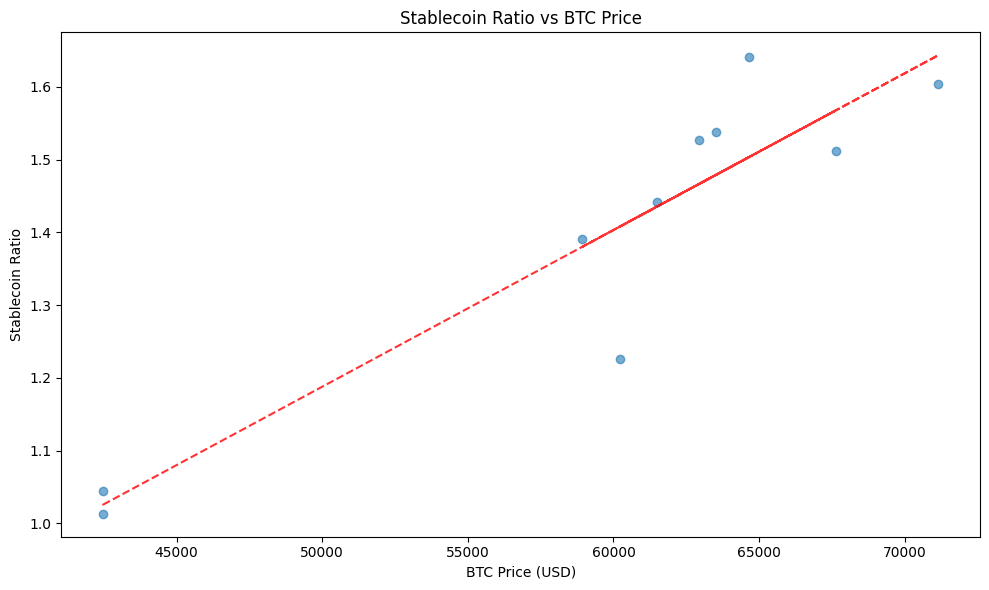

In [29]:
# Calculate the correlation between stablecoin_ratio and btc_price
correlation = monthly_usd_values['stablecoin_ratio'].corr(monthly_usd_values['btc_price'])

print(f"Correlation between Stablecoin Ratio and BTC Price: {correlation:.4f}")

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(monthly_usd_values['btc_price'], monthly_usd_values['stablecoin_ratio'], alpha=0.6)
plt.xlabel('BTC Price (USD)')
plt.ylabel('Stablecoin Ratio')
plt.title('Stablecoin Ratio vs BTC Price')

# Add a trend line
z = np.polyfit(monthly_usd_values['btc_price'], monthly_usd_values['stablecoin_ratio'], 1)
p = np.poly1d(z)
plt.plot(monthly_usd_values['btc_price'], p(monthly_usd_values['btc_price']), "r--", alpha=0.8)

plt.tight_layout()
plt.show()


## 2. Weekly data from Binance

In [2]:
df_addr = pd.DataFrame()
selected_columns_addr = ['coin', 'network', 'address']

for m in months:
    pdf = pd.read_csv(f"bn_reserved/bn_{m}.csv")
    pdf = pdf[pdf['coin'].isin(selected_coins)][selected_columns_addr]
    
    df_addr = pd.concat([df_addr, pdf])

df_addr.drop_duplicates(inplace=True)
df_addr.reset_index(drop=True)

df_addr.to_csv("bn_reserved/bn_addr.csv", index=False)

df_addr = df_addr[['coin', 'network', 'address']].drop_duplicates().reset_index(drop=True)


In [3]:
df_addr.rename(columns={'url': 'address'}, inplace=True)

# Define a dictionary for the replacements
replacements = {
    "https://explorer.btc.com/btc/search/": "",
    "https://bscscan.com/address/": "",
    "https://explorer.bnbchain.org/address/": "",
    "https://etherscan.io/address/": "",
    "https://snowtrace.io/address/": "",
    "https://polygonscan.com/address/": "",
    "https://optimistic.etherscan.io/address/": "",
    "https://tronscan.org/#/address/": "",
    "https://arbiscan.io/address/": "",
    "https://solscan.io/account/": "",
    "https://opbnbscan.com/address/": "",
    "https://tonviewer.com/": ""
}

# Apply the replacements to the 'address' column
for old, new in replacements.items():
    df_addr['address'] = df_addr['address'].str.replace(old, new, regex=False)

df_addr

,coin,network,address
0,BTC,BNB,bnb1fnd0k5l4p3ck2j9x9dp36chk059w977pszdgdz
1,BTC,BNB,bnb1lsmt5a8vqqus5fwslx8pyyemgjtg4y6ugj308t
2,BTC,BNB,bnb1u2agwjat20494fmc6jnuau0ls937cfjn4pjwtn
3,BTC,BSC,0x8894e0a0c962cb723c1976a4421c95949be2d4e3
4,BTC,BSC,0xe2fc31f816a9b94326492132018c3aecc4a93ae1
...,...,...,...
194,FDUSD,ETH,0x3a3c006053a9b40286b9951a11be4c5808c11dc8
195,USDT,BSC,0x08439901c2bb071cd0812ed329675c9657434083
196,USDT,ETH,0x3a3c006053a9b40286b9951a11be4c5808c11dc8
197,USDT,TON,UQDKHZ7e70CzqdvZCC83Z4WVR8POC_ZB0J1Y4zo88G-zCSRH


In [6]:

# Define the start and end dates
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 10, 1)

# Generate a list of Mondays between start and end dates
mondays = pd.date_range(start=start_date, end=end_date, freq='W-MON')

# Create a DataFrame with the Mondays
df_mondays = pd.DataFrame({'date': mondays})

# Set the time to 00:00 for each date
df_mondays['date'] = df_mondays['date'].apply(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))

# Create a new DataFrame by merging df_mondays and df_addr
df_merged = pd.merge(
    df_mondays.assign(key=1),
    df_addr.assign(key=1),
    on='key'
).drop('key', axis=1)

# Rename the 'date' column to 'month' for consistency with previous code
df_merged = df_merged.rename(columns={'date': 'week'})

# Initialize the 'balance' column with NaN values
df_merged['balance'] = np.nan

df_merged


,week,coin,network,address,balance
0,2024-01-01,BTC,BNB,bnb1fnd0k5l4p3ck2j9x9dp36chk059w977pszdgdz,NaN
1,2024-01-01,BTC,BNB,bnb1lsmt5a8vqqus5fwslx8pyyemgjtg4y6ugj308t,NaN
2,2024-01-01,BTC,BNB,bnb1u2agwjat20494fmc6jnuau0ls937cfjn4pjwtn,NaN
3,2024-01-01,BTC,BSC,0x8894e0a0c962cb723c1976a4421c95949be2d4e3,NaN
4,2024-01-01,BTC,BSC,0xe2fc31f816a9b94326492132018c3aecc4a93ae1,NaN
...,...,...,...,...,...
7955,2024-09-30,FDUSD,ETH,0x3a3c006053a9b40286b9951a11be4c5808c11dc8,NaN
7956,2024-09-30,USDT,BSC,0x08439901c2bb071cd0812ed329675c9657434083,NaN
7957,2024-09-30,USDT,ETH,0x3a3c006053a9b40286b9951a11be4c5808c11dc8,NaN
7958,2024-09-30,USDT,TON,UQDKHZ7e70CzqdvZCC83Z4WVR8POC_ZB0J1Y4zo88G-zCSRH,NaN


In [44]:

def get_address_balance_at_date(address, date):
    timestamp = int(date.timestamp() * 1000)
    url = f"https://blockchain.info/balance?active={address}&at={timestamp}"
    response = requests.get(url)
    data = response.json()
    return data[address]['final_balance'] / 100000000  # Convert satoshis to BTC

# Loop over df_merged and print only when coin is BTC
for index, row in df_merged.iterrows():
    if row['coin'] == 'BTC' and row['network'] == 'BTC':
        balance = get_address_balance_at_date(row['address'], row['week'])
        df_merged.at[index, 'balance'] = balance
        
df_merged.to_csv("bn_reserved/bn_addr_weekly_balance.csv", index=False, encoding='utf-8')  

In [20]:
web3 = Web3(Web3.HTTPProvider('https://bsc-dataseed.binance.org/'))
web3.middleware_onion.inject(ExtraDataToPOAMiddleware, name="extradata_to_poa", layer=0)
web3.middleware_onion.add(PythonicMiddleware, "pythonic")


# Function to get the timestamp of a block
def get_block_timestamp(block_number):
    block = web3.eth.get_block(block_number)
    return block.timestamp

# Binary search to find the block closest to the target timestamp
def get_block_by_timestamp(datetimestr):
    target_timestamp = int(datetime.strptime(datetimestr, "%Y-%m-%d").timestamp())

    # Get the latest block and the earliest block
    latest_block = web3.eth.get_block_number()
    earliest_block = 1  # Genesis block number on BNB chain

    while earliest_block <= latest_block:
        middle_block = (earliest_block + latest_block) // 2
        middle_timestamp = get_block_timestamp(middle_block)

        if middle_timestamp < target_timestamp:
            earliest_block = middle_block + 1
        elif middle_timestamp > target_timestamp:
            latest_block = middle_block - 1
        else:
            # Exact match
            return middle_block

    # Return the closest block (which is latest_block in this case)
    return latest_block if get_block_timestamp(latest_block) <= target_timestamp else earliest_block

# Get the block number for the target timestamp
block_number = get_block_by_timestamp("2024-01-01")
print(f"Block number closest to the target timestamp: {block_number}")


Block number closest to the target timestamp: 34839144


In [22]:
from web3 import Web3

# Connect to BSC node
bsc = Web3(Web3.HTTPProvider('https://bsc-dataseed.binance.org/'))

# Check if connected
if bsc.is_connected():
    print("Connected to Binance Smart Chain")

# Address of the wallet and token contract
wallet_address = "0x08439901c2bb071cd0812ed329675c9657434083"
token_contract_addr = "0xc5f0f7b66764F6ec8C8Dff7BA683102295E16409" 

# Replace 'latest' with a block number for historical balance (e.g., 10000000)
block_number = get_block_by_timestamp("2024-01-01")

# 1. Get native BNB balance at a specific block
bnb_balance = bsc.eth.get_balance(wallet_address, block_identifier=block_number)
bnb_balance_in_bnb = bsc.fromWei(bnb_balance, 'ether')
print(f"BNB Balance: {bnb_balance_in_bnb} BNB")

# 2. Interact with a BEP-20 token contract
# ABI for the BEP-20 'balanceOf' function
abi = '''
[
    {
        "constant": true,
        "inputs": [
            {
                "name": "_owner",
                "type": "address"
            }
        ],
        "name": "balanceOf",
        "outputs": [
            {
                "name": "balance",
                "type": "uint256"
            }
        ],
        "type": "function"
    }
]
'''

# Create contract instance
token_contract = bsc.eth.contract(address=Web3.to_checksum_address(token_contract_addr), abi=abi)

# Get token balance at a specific block
token_balance = token_contract.functions.balanceOf(Web3.toChecksumAddress(wallet_address)).call(block_identifier=block_number)

# Assuming the token has 18 decimals (like most BEP-20 tokens)
decimals = 18
formatted_token_balance = token_balance / (10 ** decimals)

print(f"Token Balance: {formatted_token_balance} tokens")


Connected to Binance Smart Chain


InvalidAddress: ('web3.py only accepts checksum addresses. The software that gave you this non-checksum address should be considered unsafe, please file it as a bug on their platform. Try using an ENS name instead. Or, if you must accept lower safety, use Web3.to_checksum_address(lower_case_address).', '0x08439901c2bb071cd0812ed329675c9657434083')

## to be used for calculating historical balance

In [ ]:

# BNB Chain RPC URL (you can use a different one if preferred)
bnb_rpc_url = "https://bsc-dataseed.binance.org/"

# BTC token contract address on BNB Chain
btc_token_address = "0x7130d2A12B9BCbFAe4f2634d864A1Ee1Ce3Ead9c"  # BTCB token address

# ABI for ERC20 token (this is a standard ABI for the balanceOf function)
abi = [
    {
        "constant": True,
        "inputs": [{"name": "_owner", "type": "address"}],
        "name": "balanceOf",
        "outputs": [{"name": "balance", "type": "uint256"}],
        "type": "function"
    }
]

def get_btc_balance(wallet_address):
    # Connect to BNB Chain
    w3 = Web3(Web3.HTTPProvider(bnb_rpc_url))
    w3.middleware_onion.inject(geth_poa_middleware, layer=0)

    # Ensure connection is successful
    if not w3.is_connected():
        raise Exception("Failed to connect to BNB Chain")

    # Create contract instance
    contract = w3.eth.contract(address=w3.to_checksum_address(btc_token_address), abi=abi)

    # Get balance
    balance = contract.functions.balanceOf(w3.to_checksum_address(wallet_address)).call()

    # Convert balance from wei to BTC (assuming 18 decimals)
    balance_btc = balance / 10**18

    return balance_btc

for index, row in df_merged.iterrows():
    try:
        row['balance'] = get_btc_balance(row['address'])
    except Exception as e:
        print(f"An error occurred: {e}")
    
df_merged.to_csv("bn_reserved/bn_addr_weekly_balance.csv", index=False, encoding='utf-8')  



In [69]:
# Read the BTC/USDT price data
btc_usdt_data = pd.read_csv("binance_btcusdt_data.csv")

# Convert the 'timestamp' column to datetime
btc_usdt_data['timestamp'] = pd.to_datetime(btc_usdt_data['timestamp'])

# Set 'timestamp' as the index
btc_usdt_data.set_index('timestamp', inplace=True)

# Define the date range for Mondays from 1st Jan 2024 to 1st Oct 2024
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp('2024-10-01')
mondays = pd.date_range(start=start_date, end=end_date, freq='W-MON')

# Get the closing prices for each Monday at 00:00
monday_prices = btc_usdt_data.loc[mondays, 'close']

# Create a DataFrame with the Monday prices
btc_monday_prices = pd.DataFrame({
    'date': monday_prices.index,
    'btc_price': monday_prices.values
})

# Display the first few rows of the resulting DataFrame
print(btc_monday_prices.head())

# Save the DataFrame to a CSV file
btc_monday_prices.to_csv("bn_reserved/btc_monday_prices.csv", index=False)


        date  btc_price
0 2024-01-01   42475.23
1 2024-01-08   43632.00
2 2024-01-15   42279.75
3 2024-01-22   41657.43
4 2024-01-29   41971.42


In [70]:
# Read the CSV file containing the merged data
df_merged = pd.read_csv("bn_reserved/bn_addr_weekly_balance.csv")

# Convert 'month' column to datetime
df_merged['month'] = pd.to_datetime(df_merged['month'])

# Read the BTC Monday prices
btc_monday_prices = pd.read_csv("bn_reserved/btc_monday_prices.csv")
btc_monday_prices['date'] = pd.to_datetime(btc_monday_prices['date'])

# Filter df_merged for BTC only
df_btc = df_merged[df_merged['coin'] == 'BTC'].copy()

# Merge df_btc with btc_monday_prices
df_btc_merged = pd.merge(df_btc, btc_monday_prices, left_on='month', right_on='date', how='left')

# Drop the redundant 'date' column
df_btc_merged = df_btc_merged.drop('date', axis=1)

# Calculate BTC value in USD
df_btc_merged['btc_value_usd'] = df_btc_merged['balance'] * df_btc_merged['btc_price']

# Display the first few rows of the resulting DataFrame
print(df_btc_merged.head())

# Save the merged DataFrame to a new CSV file
df_btc_merged.to_csv("bn_reserved/btc_merged_with_prices.csv", index=False)


       month coin network                                                url  \
0 2024-01-01  BTC     BNB  https://explorer.bnbchain.org/address/bnb1fnd0...   
1 2024-01-01  BTC     BNB  https://explorer.bnbchain.org/address/bnb1lsmt...   
2 2024-01-01  BTC     BNB  https://explorer.bnbchain.org/address/bnb1u2ag...   
3 2024-01-01  BTC     BSC  https://bscscan.com/address/0x8894e0a0c962cb72...   
4 2024-01-01  BTC     BSC  https://bscscan.com/address/0xe2fc31f816a9b943...   

                                      address  balance  btc_price  \
0  bnb1fnd0k5l4p3ck2j9x9dp36chk059w977pszdgdz      NaN   42475.23   
1  bnb1lsmt5a8vqqus5fwslx8pyyemgjtg4y6ugj308t      NaN   42475.23   
2  bnb1u2agwjat20494fmc6jnuau0ls937cfjn4pjwtn      NaN   42475.23   
3  0x8894e0a0c962cb723c1976a4421c95949be2d4e3      NaN   42475.23   
4  0xe2fc31f816a9b94326492132018c3aecc4a93ae1      NaN   42475.23   

   btc_value_usd  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4        